# Bridging RooFit and SymPy with applications in amplitude analysis

Jonas Rembser
PyHEP 2023

## Overview

* Introduction to RooFit
* Existing Python interoperability in RooFit
* **New:** Improvements in defining custom pdfs on-the-fly
* Defining custom pdfs from [SymPy](https://www.sympy.org/en/index.html) expressions
* Possible application in amplitude analysis
* Conclusions and possible next steps

**Note:** ROOT `master` is required to run this code, but soon it will be possible with ROOT 6.30.00 when released.

## Introduction to RooFit

RooFit is a library for statistical data modelling that is part of ROOT.

You can use it to build complicated models from simple building blocks, sample toy data and do fits:

In [1]:
import ROOT

# Disable RooFit logging for presentation
change_msg_lvl = ROOT.RooHelpers.LocalChangeMsgLevel(ROOT.RooFit.WARNING)

Welcome to JupyROOT 6.31/01


**Example -** convolution of Landau with Gaussian:

In [2]:
worksp = ROOT.RooWorkspace()

worksp.factory("Landau::lx(t[-10., 30], ml[5.0, -20, 20], sl[1, 0.1, 10])")
worksp.factory("Gaussian::gauss(t, mg[0.], sg[2, 0.1, 10])")
worksp.factory("RooFFTConvPdf::lxg(t, lx, gauss)")

# Set #bins to be used for FFT sampling to 10000
worksp["t"].setBins(10000, "cache")

Sample 10000 events and fit to this toy dataset:

In [3]:
data = worksp["lxg"].generate({worksp["t"]}, 10000)

worksp["lxg"].fitTo(data, PrintLevel=-1, Save=True).Print()


  RooFitResult: minimized FCN value: 28280.5, estimated distance to minimum: 0.000378843
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                    ml    4.8882e+00 +/-  3.71e-02
                    sg    1.8974e+00 +/-  4.64e-02
                    sl    1.0301e+00 +/-  2.93e-02



Plotting:

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


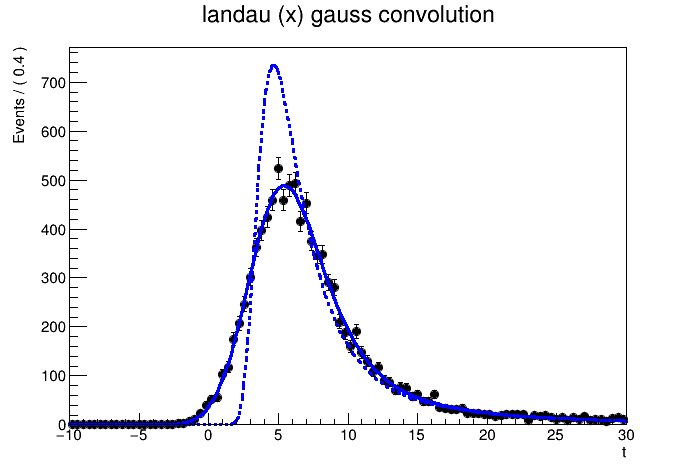

In [4]:
frame = worksp["t"].frame(Title="landau (x) gauss convolution")
data.plotOn(frame)
worksp["lxg"].plotOn(frame)
worksp["lx"].plotOn(frame, LineStyle="--")
frame.Draw()
ROOT.gPad.Draw()

### Python interoperability

RooFit has some extra functions in PyROOT for interoperabilty, like `to_pandas/numpy` and `from_pandas/numpy` for RooFit datasets. Example:

In [5]:
data.to_pandas()

,t
0,6.302545
1,6.904973
2,0.427351
3,9.532097
4,4.340893
...,...
9995,13.477871
9996,6.471149
9997,5.812208
9998,7.409787


More examples in [this tutorial](https://root.cern.ch/doc/master/rf409__NumPyPandasToRooFit_8py.html).

## Defining custom pdfs interactively

There are three different ways to implement custom pdfs:

1) Implement your own C++ class

2) With `RooGenericPdf` or `EXPR` command in RooWorkspace (will be jitted by ROOT interpreter)

In [6]:
ws = ROOT.RooWorkspace()
ws.factory(f"EXPR::gauss_1('exp(-0.5*(x - mu)*(x - mu))', x[0., 10.], mu[5., 0., 10.])");

3) With the `RooClassFactory` or `CEXPR` in the workspace (C++ code will be written to disc and compiled on-the-fly)

In [7]:
ws.factory(f"CEXPR::gauss_2('exp(-0.5*(x - mu)*(x - mu))', x, mu)");

Info in <TUnixSystem::ACLiC>: creating shared library /home/rembserj/tmp/pyhep/roofit-pyhep-2023-talk/RooCFAuto000Pdf_cxx.so


## What if the expressions become complicated?

1. You can build pdfs in a modular way with RooFit classes like `RooAddPdf` etc.

2. Alternative approach presented today: build expression tree with a different Python library (SymPy) and import to RooFit

In [8]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

Define SymPy symbols:

In [9]:
x, mu = sp.symbols('x mu')

Define Gaussian as SymPy expression tree:

In [10]:
gauss = sp.exp(-0.5*(x - mu)**2)
gauss

exp(-0.5*(-mu + x)**2)

### Back to RooFit land

The SymPy expression can be exported to C code!

In [11]:
c_code = sp.ccode(gauss)
c_code

'exp(-0.5*pow(-mu + x, 2))'

Import this as a custom RooFit pdf to use with other RooFit classes and algorithms:

In [12]:
ws = ROOT.RooWorkspace()
ws.factory(f"CEXPR::gauss('{c_code}', x[0., 10.], mu[5., 0., 10.])");

Info in <TUnixSystem::ACLiC>: creating shared library /home/rembserj/tmp/pyhep/roofit-pyhep-2023-talk/RooCFAuto001Pdf_cxx.so


In [13]:
ws.Print()


RooWorkspace()  contents

variables
---------
(mu,x)

p.d.f.s
-------
RooCFAuto001Pdf::gauss[ x=x mu=mu ] = 1

embedded class code
-------------------
RooCFAuto001Pdf



### Creating an NLL object with AD support

We can for example use it to create an NLL object that also can return the gradient. This is done with RooFits new `"codegen"` evaluation backend for [RooAbsPdf::createNLL()](https://root.cern.ch/doc/master/classRooAbsPdf.html#a24b1afec4fd149e08967eac4285800de).

This **highly experimental** backend generates simple C++ code for the NLL on the fly, and generates the gradient code from that with the [Clad](https://github.com/vgvassilev/clad) compiler plugin (more detail at this [CHEP 2023](https://indico.jlab.org/event/459/contributions/11581/) talk).

In [14]:
data = ws["gauss"].generate(ws["x"], 100)
nll = ws["gauss"].createNLL(data, EvalBackend="codegen")

input_line_186:12:51: warning: expression result unused [-Wunused-value]
      gauss_Int_x_Result +=  + roo_func_wrapper_0(tmpVar0, tmpVar0);
                                                  ^~~~~~~
input_line_186:12:60: warning: expression result unused [-Wunused-value]
      gauss_Int_x_Result +=  + roo_func_wrapper_0(tmpVar0, tmpVar0);
                                                           ^~~~~~~


We can for example do likelihood scans with this NLL object:

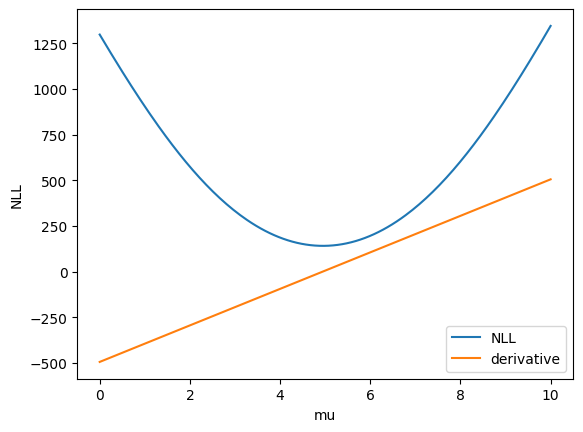

In [15]:
mu_vals = np.linspace(0.0, 10.0, 200)
nll_vals = np.zeros_like(mu_vals)
nll_grad_vals = np.zeros_like(mu_vals)

nll_grad_out = np.zeros(1)
for i, v in enumerate(mu_vals):
    ws["mu"].setVal(v)
    nll_vals[i] = nll.getVal()

    # The experimental interface here will be improved in the future:
    nll_grad_out[0] = 0.0
    nll.gradient(nll_grad_out)
    nll_grad_vals[i] = nll_grad_out[0]
    
plt.plot(mu_vals, nll_vals, label="NLL")
plt.plot(mu_vals, nll_grad_vals, label="derivative")
plt.legend()
plt.xlabel("mu")
plt.ylabel("NLL")
plt.show()

## Possible application in amplitude analysis

This approach unlocks more usecase for RooFit!

For example, when using the nice [qrules](https://qrules.readthedocs.io/en/stable/usage.html#main-interface) and [ampform](https://ampform.readthedocs.io/en/stable/) packages from the ComPWA project, which builds complicated amplitudes as SymPy expression (taken from [this tutorial](https://compwa-org.readthedocs.io/report/020.html)):

In [16]:
import qrules

reaction = qrules.generate_transitions(
    initial_state=("J/psi(1S)", [-1, +1]),
    final_state=["gamma", "pi0", "pi0"],
    allowed_intermediate_particles=["f(0)"],
    allowed_interaction_types=["strong", "EM"],
    formalism="helicity",
)

/home/rembserj/spaces/master/install/lib/ROOT/_facade.py:154: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)
Propagating quantum numbers: 100%|███████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.63it/s]


The previous code generated for example the information on the transition from a $J/\psi$ to $\pi_0\pi_0\gamma$:

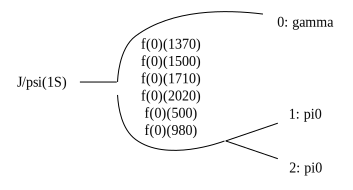

In [17]:
import graphviz

dot = qrules.io.asdot(reaction, collapse_graphs=True)
graphviz.Source(dot)

With `ampform`, one can build the SymPy expression 

In [18]:
import ampform
from ampform.dynamics.builder import (
    create_non_dynamic_with_ff,
    create_relativistic_breit_wigner_with_ff,
)

model_builder = ampform.get_builder(reaction)
model_builder.scalar_initial_state_mass = True
model_builder.stable_final_state_ids = [0, 1, 2]
model_builder.set_dynamics("J/psi(1S)", create_non_dynamic_with_ff)
for name in reaction.get_intermediate_particles().names:
    model_builder.set_dynamics(name, create_relativistic_breit_wigner_with_ff)

model = model_builder.formulate()

Unfold the expression to closed form:

In [19]:
unfolded_expression = model.expression.doit()

**Warning -** Run this cell if you dare, but the huge LaTeX output makes the notebook very slow:

In [20]:
# unfolded_expression

### Getting the fitting model expression

In [21]:
def make_valid_name(name):
    """Turn name into valid C++ variable name.
    """
    out = name
    for s in ["\\", "{", "}", "(", ")", "^", " ", "/", "+", ";"]:
        out = out.replace(s, " ")
    out = out.strip().replace(" ", "_")
    while "__" in out:
        out = out.replace("__", "_")

    # To make the variable names a bit simpler in special cases
    if out == "C_J_psi_1S_to_f_0_1500_0_gamma_1_f_0_1500_to_pi_0_0_pi_0_0":
        return "C"
    
    return out

In [22]:
initial_parameters = {
    R"C_{J/\psi(1S) \to {f_{0}(1500)}_{0} \gamma_{+1}; f_{0}(1500) \to \pi^{0}_{0} \pi^{0}_{0}}": 1.0,
    "m_{f_{0}(500)}": 0.4,
    "m_{f_{0}(980)}": 0.88,
    "m_{f_{0}(1370)}": 1.22,
    "m_{f_{0}(1500)}": 1.45,
    "m_{f_{0}(1710)}": 1.83,
    R"\Gamma_{f_{0}(500)}": 0.3,
    R"\Gamma_{f_{0}(980)}": 0.1,
    R"\Gamma_{f_{0}(1710)}": 0.3,
}

In [23]:
new_param_names = {}
new_param_defaults = {}
fixed_parameters = {}

for key, val in model.parameter_defaults.items():
    name = str(key)
    if name not in initial_parameters:
        fixed_parameters[key] = val
    else:
        new_name = make_valid_name(name)
        new_param_names[key] = sp.symbols(new_name)
        new_param_defaults[key] = initial_parameters[name]
        
replacements = {**new_param_names, **fixed_parameters}

To get the expression for fitting, we rename the parameter symbols to something that is valid in RooFit (valid C++ variable names).

The code to get `replacements` is skipped in presentation mode because it's not so interesting.

In [24]:
fitting_expression = unfolded_expression.xreplace(replacements)

Check that the list of parameters looks good:

In [25]:
fitting_expression.free_symbols

{C,
 Gamma_f_0_1710,
 Gamma_f_0_500,
 Gamma_f_0_980,
 m_12,
 m_f_0_1370,
 m_f_0_1500,
 m_f_0_1710,
 m_f_0_500,
 m_f_0_980,
 phi_0,
 theta_0}

### Getting the C code

Just like in the simple example, we can now get the C code for this expression:

In [26]:
c_code = sp.ccode(fitting_expression)

In [27]:
c_code[:2000] + "..."

'pow(fabs(0.16723260000000001*M_SQRT2*C*m_f_0_1500*((1.0/2.0)*cos(theta_0) - 1.0/2.0)*exp(-I*phi_0)*fabs(0.10426670176951153*pow(m_12, 2) - 1)/(sqrt(0.026066675442377885*(91.983245343283983*pow(1 - 0.10426670176951153*pow(m_12, 2), 2)) + 1)*(pow(m_12, 2) - pow(m_f_0_1500, 2) + 0.108*I*pow(m_f_0_1500, 2)*sqrt(pow(m_12, 2) - 0.072874946152960002)/(m_12*sqrt(pow(m_f_0_1500, 2) - 0.072874946152960002)))) + 1.5484500000000003*M_SQRT2*Gamma_f_0_1710*m_f_0_1710*((1.0/2.0)*cos(theta_0) - 1.0/2.0)*exp(-I*phi_0)*fabs(0.10426670176951153*pow(m_12, 2) - 1)/(sqrt(0.026066675442377885*(91.983245343283983*pow(1 - 0.10426670176951153*pow(m_12, 2), 2)) + 1)*(I*Gamma_f_0_1710*pow(m_f_0_1710, 2)*sqrt(pow(m_12, 2) - 0.072874946152960002)/(m_12*sqrt(pow(m_f_0_1710, 2) - 0.072874946152960002)) + pow(m_12, 2) - pow(m_f_0_1710, 2))) + 1.5484500000000003*M_SQRT2*Gamma_f_0_500*m_f_0_500*((1.0/2.0)*cos(theta_0) - 1.0/2.0)*exp(-I*phi_0)*fabs(0.10426670176951153*pow(m_12, 2) - 1)/(sqrt(0.026066675442377885*(91.983

In [28]:
len(c_code)

9521

**Important note:** The code contains the imaginary unit `I`! The `RooClassFactory` will only support this with the upcoming ROOT version 6.30.

### Setting up the RooFit workspace

Populate the workspace with observables:

In [29]:
ws_2 = ROOT.RooWorkspace()
m_12 = ws_2.factory("m_12[0.4, 3.]")
phi_0 = ws_2.factory("phi_0[0., 2. * M_PI]")
theta_0 = ws_2.factory("theta_0[0., 2. * M_PI]")

m_12.setConstant()
phi_0.setConstant()
theta_0.setConstant()

Define parameters with limits for the minimizer that are a factor two away from the nominal value:

In [30]:
params = []

for key, val in new_param_defaults.items():
    name = str(new_param_names[key])
    def_val = new_param_defaults[key]
    params.append(ws_2.factory(f"{name}[{def_val}, {def_val * 0.5}, {def_val * 2}]"))

Create the custom pdf:

In [31]:
genpdf = ROOT.RooClassFactory.makePdfInstance("genpdf", c_code, [m_12, phi_0, theta_0, *params])

Info in <TUnixSystem::ACLiC>: creating shared library /home/rembserj/tmp/pyhep/roofit-pyhep-2023-talk/RooGenpdfPdf_cxx.so


**Note:** ROOT 6.30 improves how the `RooClassFactory` behave in a notebook! The cell above can now be re-run without crashing.

In [32]:
ws_2.Import(genpdf);

Let's make this example a bit more interesting by doing the convolution of the intensity with a Gaussian **resolution function**:

In [33]:
ws_2.factory("Gaussian::resolution(m_12, 0.0, sigma[0.1, 0.001, 0.05])");
ws_2["m_12"].setBins(1000, "cache") # number of sampling bins for convolution

ws_2.factory("RooFFTConvPdf::convpdf(m_12, genpdf, resolution)");

In [34]:
ws_2.Print()


RooWorkspace()  contents

variables
---------
(C,Gamma_f_0_1710,Gamma_f_0_500,Gamma_f_0_980,m_12,m_f_0_1370,m_f_0_1500,m_f_0_1710,m_f_0_500,m_f_0_980,phi_0,sigma,theta_0)

p.d.f.s
-------
RooFFTConvPdf::convpdf[ genpdf(m_12) (*) resolution(m_12) ] = 6.14111e+07
RooGenpdfPdf::genpdf[ m_12=m_12 phi_0=phi_0 theta_0=theta_0 m_f_0_500=m_f_0_500 Gamma_f_0_500=Gamma_f_0_500 m_f_0_980=m_f_0_980 Gamma_f_0_980=Gamma_f_0_980 m_f_0_1370=m_f_0_1370 m_f_0_1500=m_f_0_1500 C=C m_f_0_1710=m_f_0_1710 Gamma_f_0_1710=Gamma_f_0_1710 ] = 2.04151
RooGaussian::resolution[ x=m_12 mean=0 sigma=sigma ] = 9.50144e-252

named sets
----------

embedded precalculated expensive components
-------------------------------------------
uid = 0 key=convpdf_genpdf_CONV_resolution_CACHEHIST_Obs[m_12]_BufFrac0.1_BufStrat0 value=RooDataHist::convpdf_genpdf_CONV_resolution_CACHEHIST_Obs[m_12]_BufFrac0.1_BufStrat0 parameters=( C=1 Gamma_f_0_1710=0.3 Gamma_f_0_500=0.3 Gamma_f_0_980=0.1 m_f_0_1370=1.22 m_f_0_1500=1.45 m_f_0_1710

### Generating toy dataset and do plotting

**Warning -** The toy dataset that is created here does not necessarily make physical sense, because it is not produced with the correctly-constrained phase space sampling.

But for demonstrating that RooFit can handle complicated SymPy expressions it should not bother us.

In [35]:
data = ws_2["convpdf"].generate(m_12, 10000)

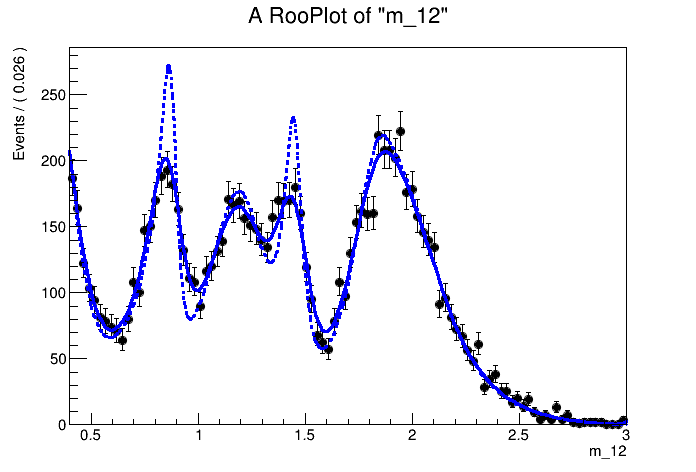

In [36]:
frame = m_12.frame()
data.plotOn(frame)
ws_2["genpdf"].plotOn(frame, LineStyle="--") # no Gaussian convolution
ws_2["convpdf"].plotOn(frame) # with Gaussian convolution
frame.Draw()
ROOT.gPad.Draw()

### Fitting

Here, we can't use the `"codegen"` backend yet because it doesn't support complex numbers for the gradient.

In [37]:
%%time
result = ws_2["convpdf"].fitTo(data, Save=True, PrintLevel=-1)

CPU times: user 5.11 s, sys: 26 ms, total: 5.14 s
Wall time: 5.13 s


In [38]:
result.Print()


  RooFitResult: minimized FCN value: 6833.63, estimated distance to minimum: 0.000281161
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                     C    1.0399e+00 +/-  4.80e-02
        Gamma_f_0_1710    3.1668e-01 +/-  2.37e-02
         Gamma_f_0_500    3.2823e-01 +/-  4.34e-02
         Gamma_f_0_980    9.5062e-02 +/-  7.10e-03
            m_f_0_1370    1.2161e+00 +/-  8.21e-03
            m_f_0_1500    1.4430e+00 +/-  4.64e-03
            m_f_0_1710    1.8365e+00 +/-  6.09e-03
             m_f_0_500    3.9585e-01 +/-  9.30e-03
             m_f_0_980    8.7995e-01 +/-  4.43e-03
                 sigma    5.0000e-02 +/-  3.13e-02



Successfully converges in reasonable time.

### Conclusions and possible next steps

**Conclustions:**

* **SymPy** is a quite useful to define expressions that can be used in many contexts, e.g. exported to TensorFlow/JAX for Python libraries, or exported to C for **RooFit**
* RooFit can deal with complex SymPy expressions, like the ones used in amplitude analysis
* Lots of opportunities to mix and match tools according to the physicist needs!

**Possible next steps for RooFit**

* Also generate and compile a **CUDA** Kernel with the code
  * Could be implemented if needed, but ROOT does not have the tools to compile CUDA on the fly yet
* Make the `RooClassFactory` interfaces more pythonic

Thanks for you attention! Please reach out to me if you have more ideas about these developments.